## Score Predictions

- The competition uses `Gini`

In [157]:
from pathlib import Path
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (accuracy_score, classification_report,
                             roc_auc_score, roc_curve)

from src.metrics import Gini
from src.process import load_train_test

### Params

In [5]:
DIR = Path("data")
PLOT_DIR = DIR.joinpath("Plots")

LABEL = "target"
TRUE_LABEL = "actual"
PRED_LABEL = "pred_label"
PRED_BASELINE = "pred_baseline"
LABEL_BASELINE = "label_baseline"

In [162]:

FNAME_BASE = DIR.joinpath("baseline_predictions_cv.csv")
# FNAME_BASE = DIR.joinpath("data/baseline_predictions.csv")
FNAME_MODEL = DIR.joinpath("prediction.snap.parquet")
FNAME_MODEL = DIR.joinpath("cv_scores2.snap.parquet")

### Load Data

In [163]:
train, test = load_train_test()

dfbase = pd.read_csv(FNAME_BASE).rename(
    columns={"pred": "pred_baseline", "pred_label": "label_baseline", LABEL: TRUE_LABEL}
)


In [164]:
FNAME_MODEL

PosixPath('data/cv_scores2.snap.parquet')

In [166]:
THRESH = .08
# dfpred = pd.read_parquet(FNAME_MODEL)
dfpred = pd.read_csv('data/sample_cv_scores.csv')
dfpred = pd.read_parquet(FNAME_MODEL)
# if "target" in dfpred.columns and PRED_MODEL not in dfpred.columns:
#     dfpred = dfpred.rename(columns={"target": PRED_MODEL})
# if LABEL_MODEL not in dfpred.columns:
#     dfpred[LABEL_MODEL] = np.where(dfpred[PRED_MODEL] >= THRESH, 1, 0)


dfpred[PRED_LABEL] = np.where(dfpred[LABEL] >= THRESH, 1, 0)
dfscore = dfbase.merge(dfpred[["id"] + [LABEL, PRED_LABEL]], on="id", how="inner")

## Score Models

- Simple `Gini` - tournament criteria
- Classification Report
    - accuracy
    - precision
    - recall
    - f1
- ROC Curves


### Initial Thoughts and Summary
- My initial model receives a `.2889` cv Gini which appears competitive from the private leaderboard (top 500).
    - Not bad with no ensembling and minimal tuning
- The "baseline" provided achieves a `.2936` cv Gini which is very good.. good enough to place 3rd in the competition which seems extremely unlikely. It is highly likely to be overfit to the training data which I will demonstrate.
    - In the real world I can usually gather more test data and quickly demonstrate a model is over-fitting
    - Since I don't have that ability here I can use some other methods
    - Many entries shot significantly higher on the private leaderboard compared to public
        - indicative that overfitting is very common in this competition
        - Why would that be? There's many uniformative features, given the nature of tuning and submitting people are effectively overfitting to the public leaderboard and do much worse when the private leaderboard is later released.
        - a good model here should do well on local cv but not suspiciously well

In [167]:
baseline_gini = Gini(dfscore[TRUE_LABEL], dfscore[PRED_BASELINE])
model_gini = Gini(dfscore[TRUE_LABEL], dfscore[LABEL])

print(f"Baseline Gini: {baseline_gini:.4f}")
print(f"Model Gini: {model_gini:.4f}")

Baseline Gini: 0.2936
Model Gini: 0.2861


In [168]:
%%capture

### Score each model

dfscore["pred_naive"] = 0

acc_naive = accuracy_score(dfscore[TRUE_LABEL], dfscore["pred_naive"]) * 100
acc_baseline = accuracy_score(dfscore[TRUE_LABEL], dfscore[LABEL_BASELINE]) * 100
acc_model = accuracy_score(dfscore[TRUE_LABEL], dfscore[PRED_LABEL]) * 100

rep_naive = classification_report(dfscore[TRUE_LABEL], dfscore["pred_naive"])
rep_baseline = classification_report(dfscore[TRUE_LABEL], dfscore[LABEL_BASELINE])
rep_model = classification_report(dfscore[TRUE_LABEL], dfscore[PRED_LABEL])

roc_naive = roc_auc_score(dfscore[TRUE_LABEL], dfscore["pred_naive"])
roc_base = roc_auc_score(dfscore[TRUE_LABEL], dfscore[PRED_BASELINE])
roc_model = roc_auc_score(dfscore[TRUE_LABEL], dfscore[LABEL])


model_gini = Gini(dfscore[TRUE_LABEL], dfscore[LABEL])
baseline_gini = Gini(dfscore[TRUE_LABEL], dfscore["pred_baseline"])

In [169]:
## Summarise Scores by Model

print("--" * 30)
print("\t\tScoring Summary by Model")
print("--" * 30)

print(f"\t\tBaseline Gini: {model_gini:.4f}")
print(f"\t\tModel Gini: {baseline_gini:.4f}")
print("--" * 30)

print(f"""\t\tAccuracy (Naive): {acc_naive:.3f}%""")
print(f"""\t\tAccuracy (Baseline): {acc_baseline:.3f}%""")
print(f"""\t\tAccuracy (Model): {acc_model:.3f}%""")

print("--" * 30)

print(f"""\t\tROC AUC (Naive): {roc_naive:.3f}""")
print(f"""\t\tROC AUC (Baseline): {roc_base:.3f}""")
print(f"""\t\tROC AUC (Model): {roc_model:.3f}""")

print("--" * 30)
print(f"""Classification Report (Naive):\n{"--"*30}\n{rep_naive }""")
print("--" * 30)
print(f"""Classification Report (Baseline):\n{"--"*30}\n{rep_baseline}""")

print("--" * 30)
print(f"""Classification Report (Model):\n{"--"*30}\n{rep_model}""")

------------------------------------------------------------
		Scoring Summary by Model
------------------------------------------------------------
		Baseline Gini: 0.2861
		Model Gini: 0.2936
------------------------------------------------------------
		Accuracy (Naive): 96.355%
		Accuracy (Baseline): 96.359%
		Accuracy (Model): 93.042%
------------------------------------------------------------
		ROC AUC (Naive): 0.500
		ROC AUC (Baseline): 0.647
		ROC AUC (Model): 0.643
------------------------------------------------------------
Classification Report (Naive):
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    573518
           1       0.00      0.00      0.00     21694

    accuracy                           0.96    595212
   macro avg       0.48      0.50      0.49    595212
weighted avg       0.93      0.96      0.95    595212

---------------------------------------

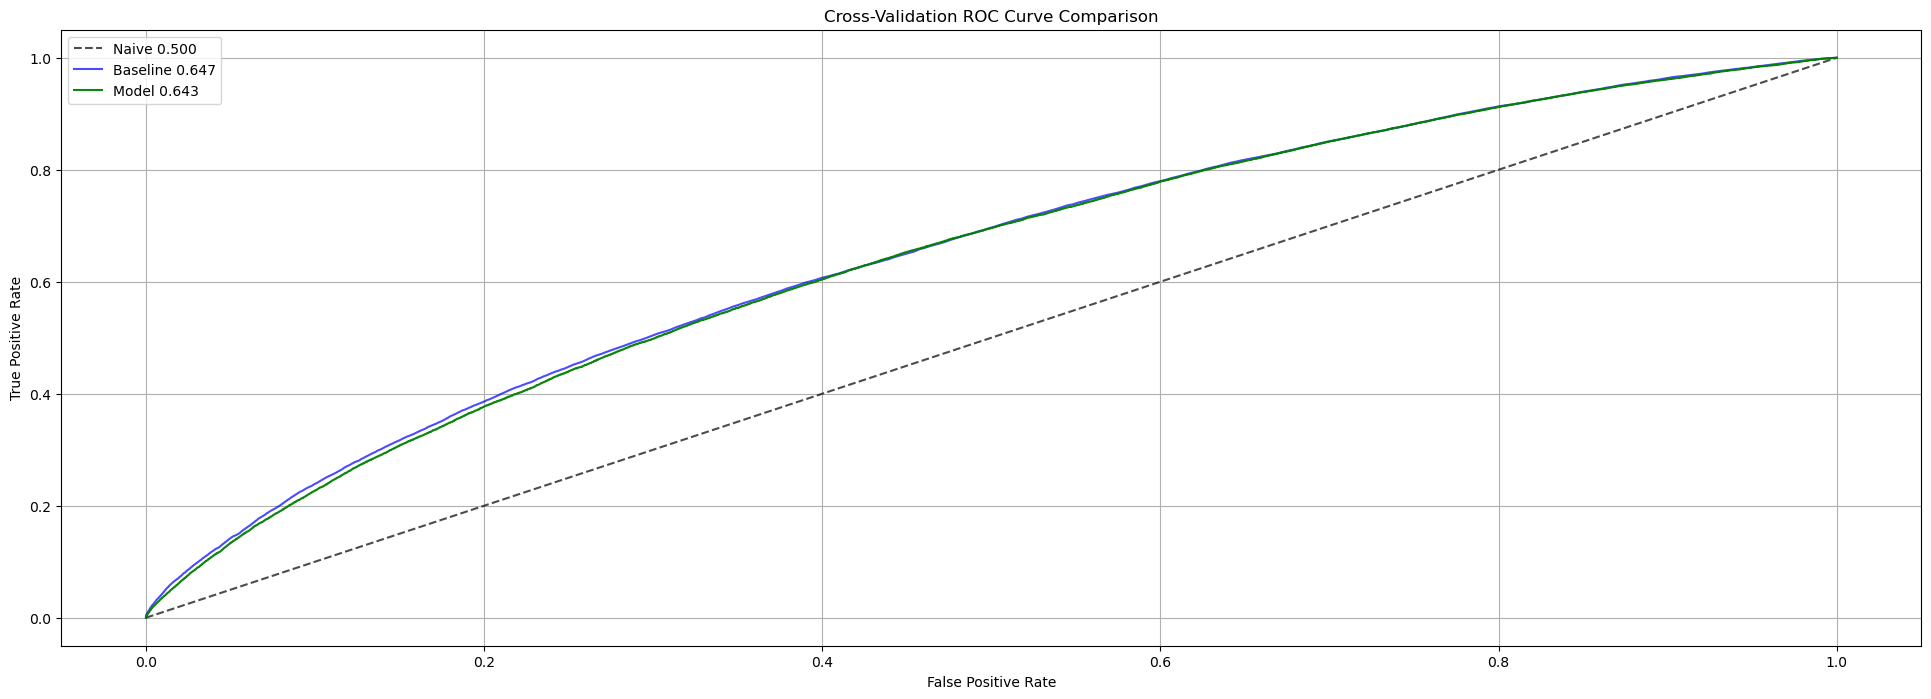

In [170]:
# Generate ROC Curve Comparison

fpr_naive, tpr_naive, _ = roc_curve(dfscore[TRUE_LABEL], dfscore["pred_naive"])
fpr_baseline, tpr_baseline, _ = roc_curve(dfscore[TRUE_LABEL], dfscore["pred_baseline"])
fpr, tpr, _ = roc_curve(dfscore[TRUE_LABEL], dfscore[LABEL])

plt.plot(fpr_naive, tpr_naive, label=f"Naive {roc_naive:.3f}", alpha=0.7, color="black", linestyle="--")
plt.plot(fpr_baseline, tpr_baseline, label=f"Baseline {roc_base:.3f}", color="Blue", alpha=0.7)
plt.plot(fpr, tpr, label=f"Model {roc_model:.3f}", color="Green", alpha=0.95)

plt.legend(loc="upper left")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.rcParams["figure.figsize"] = (24, 8)
plt.title("Cross-Validation ROC Curve Comparison")
plt.grid()
fname = PLOT_DIR.joinpath("cross-validation-roc_curve_comparison.png")
plt.savefig(fname)
plt.show()

### Test Predictions:

- Check distribution of positive predictions
    - do both predict approximately the mean ~`.03`
        - my model: yes
        - baseline: no

In [192]:
FNAME_TEST_BASELINE = "data/baseline_predictions.csv"
FNAME_TEST_MODEL = f"data/cv_scores2.snap.parquet"
FNAME_TEST_MODEL = f"data/model_scores2.snap.parquet"

In [184]:
dft_base = pd.read_csv(FNAME_TEST_BASELINE).drop(LABEL, axis=1)
dft = pd.read_parquet(FNAME_TEST_MODEL)
dftest = dft.merge(dft_base.rename(columns={"pred": PRED_BASELINE, "pred_label": LABEL_BASELINE}), on=["id"])
dftest[PRED_LABEL] = np.where(dftest[LABEL] >= THRESH, 1, 0)
dftest.head()

,id,target,pred_baseline,label_baseline,pred_label
0,0,0.029456,0.0288,0,0
1,1,0.024376,0.0247,0,0
2,2,0.023228,0.0345,0,0
3,3,0.014018,0.0171,0,0
4,4,0.037710,0.1594,0,0


In [143]:
# dftest[PRED_LABEL] = pd.Categorical(dftest[PRED_LABEL])
# dftest[LABEL_BASELINE] = pd.Categorical(dftest[LABEL_BASELINE])

In [185]:
dftest[PRED_LABEL].value_counts(normalize=True)

0    0.960756
1    0.039244
Name: pred_label, dtype: float64

In [186]:
dftest[PRED_LABEL].value_counts()

0    857778
1     35038
Name: pred_label, dtype: int64

In [187]:
dftest[LABEL_BASELINE].value_counts()

0    892754
1        62
Name: label_baseline, dtype: int64

In [188]:
dftest[LABEL_BASELINE].value_counts(normalize=True)

0    0.999931
1    0.000069
Name: label_baseline, dtype: float64

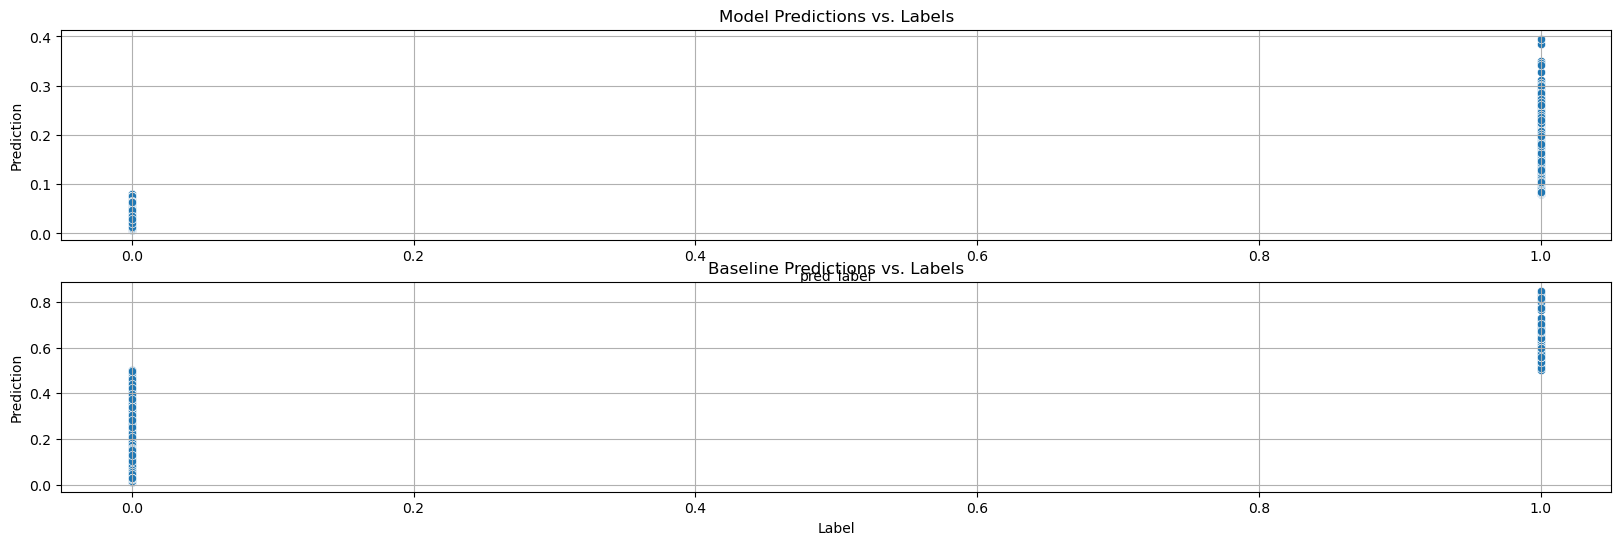

In [189]:
f, ax = plt.subplots(2, 1, figsize=(20, 6))

sns.scatterplot(dftest, x=PRED_LABEL, y=LABEL, ax=ax[0])
ax[0].set_ylabel("Prediction")
# ax[0].set_xlabel("Prediction")
ax[0].set_title("Model Predictions vs. Labels")
ax[0].grid()

sns.scatterplot(dftest, x=LABEL_BASELINE, y=PRED_BASELINE, ax=ax[1])
ax[1].set_ylabel("Prediction")
ax[1].set_xlabel("Label")
ax[1].set_title("Baseline Predictions vs. Labels")
ax[1].grid()

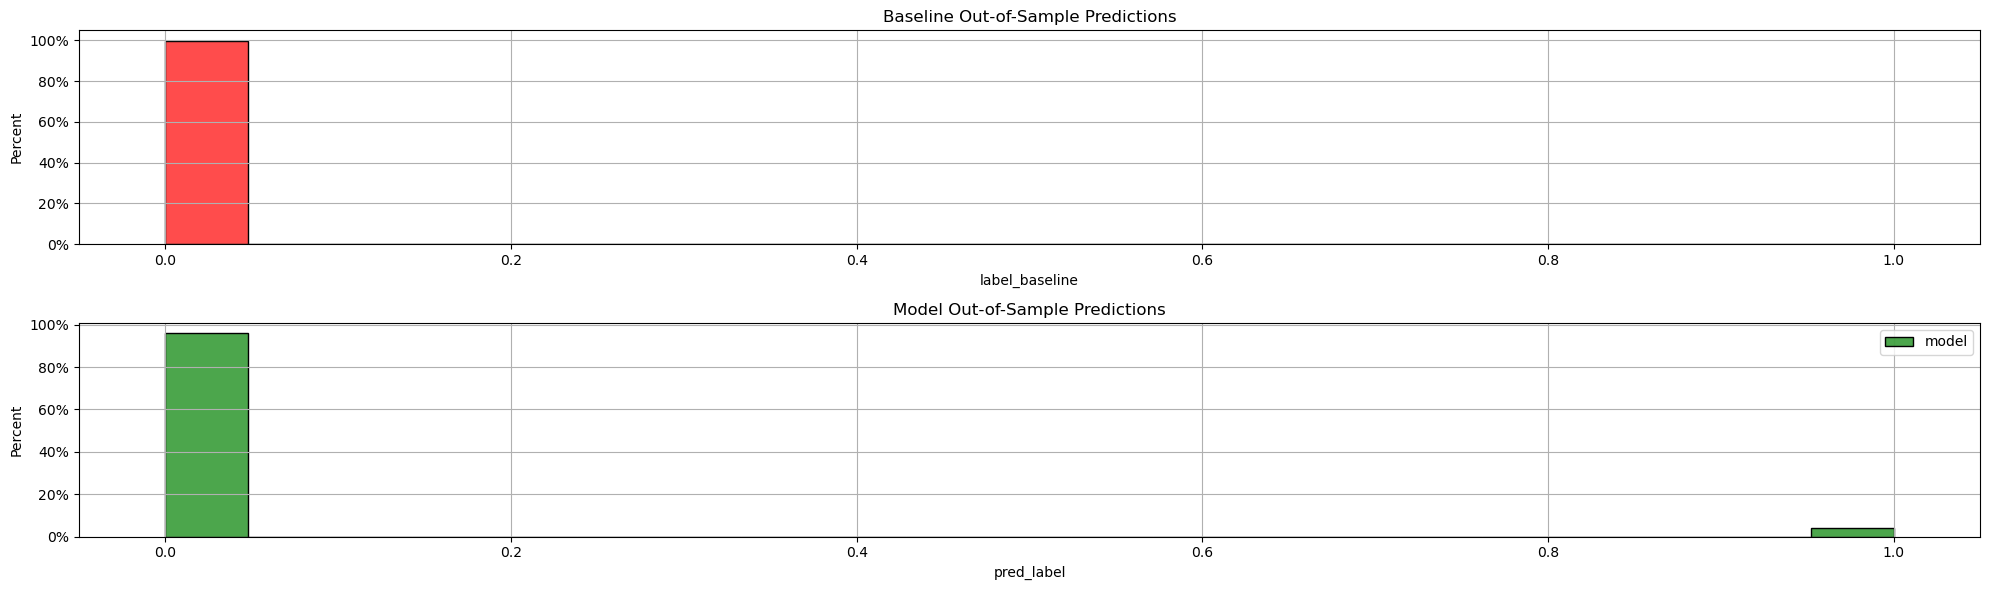

In [190]:
f, ax = plt.subplots(2, 1, figsize=(20, 6), tight_layout=True)
sns.histplot(dftest, x=LABEL_BASELINE, ax=ax[0], stat="percent", color="red", label="baseline", multiple="stack", alpha=.7)
sns.histplot(dftest, x=PRED_LABEL, ax=ax[1], stat="percent", color="green", label="model", multiple="stack", alpha=.7)
plt.legend(loc="best")
ax[0].grid()
ax[1].grid()

ax[0].set_title("Baseline Out-of-Sample Predictions")
ax[1].set_title("Model Out-of-Sample Predictions")

ax[0].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
ax[1].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())

plt.show()